In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-poster')
from train_utils import DotDict
from linear_modeling import default_cfg, run_training, MultiLayerMLP
from ae_modeling import run_ae_training, MLPAutoEncoder
from tqdm import tqdm

In [2]:
data_path = 'data/raw/geoSSL-ucmerced.pt'
data = torch.load(data_path)

In [5]:
X_tr = data['train']['Z']
y_tr = data['train']['y'].long()
X_te = data['val']['Z']
y_te = data['val']['y'].long()

# print(X_tr.min(), X_tr.max())
# print(X_te.min(), X_te.max())

In [6]:
import os
os.environ['WANDB_CONSOLE'] = 'off'

In [14]:
cfg = DotDict(
        features_base='geoSSL-ucmerced',
        compress_type=None,
        # model_type='multi_mlp',
        n_epochs=1000,
        lr=1e-4,
        wd=0,#3e-5,
        bsz=256,
        device='cuda:0'
    )

# baseline stuff

In [12]:
cfg.compress_type = 'raw'

In [13]:
z_dim = X_tr.shape[-1]
model = MultiLayerMLP(dims=[z_dim, 2048, 1024, 62], dropouts=[.5,.5])

In [14]:
run_name = 'fmow-baseline-mlp3'
run_training(X_tr, y_tr, X_te, y_te, run_name=run_name, cfg=cfg, model=model)

prepping for training
starting training


best=0.694: 16%|███████████████████▌                                                                                                         |12764/81450Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd357331ee0>
Traceback (most recent call last):
  File "/atlas2/u/clcp/miniconda3/envs/mae/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/atlas2/u/clcp/miniconda3/envs/mae/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/atlas2/u/clcp/miniconda3/envs/mae/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd357331ee0>
Traceback (most recent call last):
  File "/atlas2/u/clcp/miniconda3/envs/mae/lib/python3.

best_val acc,▁
train acc,▁▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
train loss,█▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val acc,▁▄▅▆▆▇▇▇▇▇█████████████████████▇████▇███
val loss,▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
best_val acc,0.70882
train acc,0.93902
train loss,0.19571
val acc,0.70517
val loss,1.37108


# Eig projections

In [10]:
def get_eigs(X):
    mu = X.mean(dim=0)
    X = X - mu
    cov = X.T @ X
    cov /= (len(X) - 1)
    e_vals, e_vecs = map(torch.real, torch.linalg.eig(cov))
    sort_order = torch.argsort(-e_vals)
    e_vals = e_vals[sort_order]
    e_vecs = e_vecs[:, sort_order]
    return e_vals, e_vecs
    
def eig_compress(X, U=None, proj_size=100):
    if U is None:
        _, U = get_eigs(X)
        U_trunc = U[:, :proj_size]
    else:
        U_trunc = U
    X_proj = X @ U_trunc
    return X_proj, U_trunc

def eig_decompress(X_proj, U):
    return X_proj @ U.T

In [12]:
proj_sizes = [200] # range(100, 201, 25) #[10, 30, 100, 300, 1000]

## get projections

In [21]:
e_vals, e_vecs = get_eigs(X_tr)

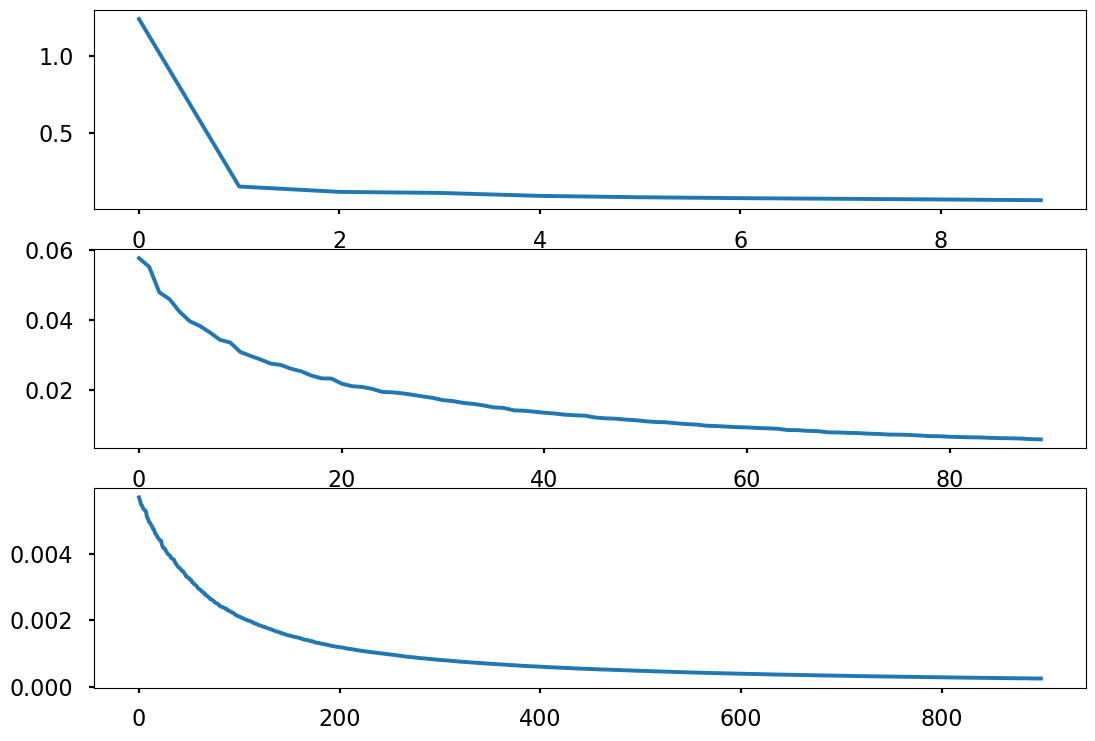

In [23]:
fig, ax = plt.subplots(3)
ax[0].plot(e_vals[:10])
ax[1].plot(e_vals[10:100])
ax[2].plot(e_vals[100:1000])
plt.show()

In [11]:
# projectors = {}
# for psz in proj_sizes:
#     save_name = f'geoSSL-fmow-center_eig_proj'
#     data = torch.load(f'data/comp/{save_name}{psz}.pt')
#     projectors[f'{save_name}{psz}'] = data['U']
# for psz in [10, 30, 100, 300, 1000]:
#     name = f'geoSSL-fmow-eig_proj{psz}'
#     data = torch.load(f'data/comp/{name}.pt')
#     projectors[name] = data['U']

In [12]:
# for k,v in projectors.items():
#     torch.save(v,f"compress_models/{k}.pt")

saving proj_size 75...
proj_size 75 done
saving proj_size 100...
proj_size 100 done
saving proj_size 125...
proj_size 125 done
saving proj_size 150...
proj_size 150 done
saving proj_size 175...
proj_size 175 done
saving proj_size 200...
proj_size 200 done


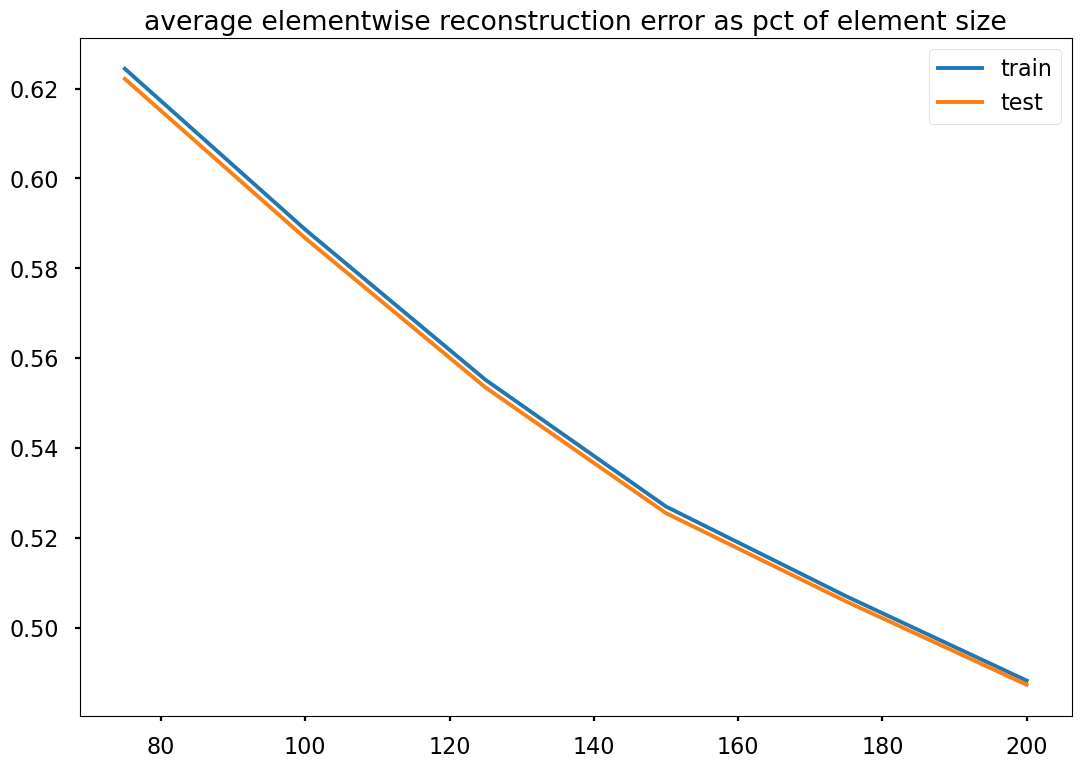

In [25]:
train_errors = []
test_errors = []
save_name = f'geoSSL-fmow-center_eig_proj'
tr_size = X_tr.abs().mean()
te_size = X_te.abs().mean()
for psz in proj_sizes:
    X_tr_proj, U_trunc = eig_compress(X_tr, U=e_vecs, proj_size=psz)
    X_te_proj, _ = eig_compress(X_te, U=e_vecs, proj_size=psz)
    
    X_tr_approx = eig_decompress(X_tr_proj, U_trunc)
    X_te_approx = eig_decompress(X_te_proj, U_trunc)
    
    print(f'saving proj_size {psz}...')
    comp_data = {
        'train':{
            'Z': X_tr_proj,
            'y': y_tr
        },
        'test': {
            'Z': X_te_proj,
            'y': y_te
        },
        'U': U_trunc
    }
    torch.save(comp_data, f'data/comp/{save_name}{psz}.pt') # saving for filesize purposes
    
    tr_err = (X_tr - X_tr_approx).abs().mean()
    train_errors.append(tr_err/tr_size)
    te_err = (X_te - X_te_approx).abs().mean()

    test_errors.append(te_err/te_size)
    print(f'proj_size {psz} done')
fig, ax = plt.subplots()
ax.plot(proj_sizes, train_errors, label='train')
ax.plot(proj_sizes, test_errors, label='test')
ax.legend()
ax.set_title('average elementwise reconstruction error as pct of element size')
plt.show()

### generalizing to other datasets

In [29]:
save_name = f'geoSSL-ucmerced-center_eig_proj'
for psz in tqdm(proj_sizes):
    load_name = f'geoSSL-fmow-center_eig_proj{psz}'
    U = torch.load(f"compress_models/{load_name}.pt")
    X_tr_proj, _ = eig_compress(X_tr, U=U)
    X_te_proj, _ = eig_compress(X_te, U=U)
    comp_data = {
        'train':{
            'Z': X_tr_proj,
            'y': y_tr
        },
        'test': {
            'Z': X_te_proj,
            'y': y_te
        }
    }
    torch.save(comp_data, f'data/comp/{save_name}{psz}.pt') # saving for filesize purposes

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 32.48it/s]


## training on projected approximations

In [11]:
cfg.compress_type = 'center_eig_proj'

In [13]:
for psz in proj_sizes:
    base_name = f'geoSSL-fmow-center_eig_proj{psz}'
    data_path = f'data/comp/{base_name}.pt'
    model_path = f'compress_models/geoSSL-fmow-center_eig_proj{psz}.pt'
    data = torch.load(data_path)
    X_tr_proj = data['train']['Z']
    y_tr_apx = data['train']['y']
    X_te_proj = data['test']['Z']
    y_te_apx = data['test']['y']
    
    U = torch.load(model_path)
    X_tr_apx = eig_decompress(X_tr_proj, U)
    X_te_apx = eig_decompress(X_te_proj, U)
    
    z_dim = X_tr_apx.shape[-1]
    model = MultiLayerMLP(dims=[z_dim, 2048, 1024, 62], dropouts=[.5,.5])

    run_name = base_name+'-mlp'
    run_training(X_tr_apx, y_tr_apx, X_te_apx, y_te_apx, run_name=run_name, cfg=cfg, model=model)

prepping for training
starting training


wandb: Currently logged in as: cpolzak. Use `wandb login --relogin` to force relogin


best=0.705: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|162900/162900


best_val acc,▁
train acc,▁▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
train loss,█▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▁▄▆▆▇▇██████████████████████████████████
val loss,█▄▃▂▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇
best_val acc,0.70462
train acc,0.88897
train loss,0.3433
val acc,0.70119
val loss,1.28819


# scale prior

In [58]:
from scale_prior_comp.compress import create_compressor, train_compressor
from torch.utils.data import DataLoader, TensorDataset
import time
SEED = 269

In [42]:
def set_seed(SEED):
    np.random.seed(SEED)
    np_rng = np.random.default_rng(seed=SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

In [43]:
set_seed(SEED)

## train compressor

In [41]:
def do_train(load_path, compressor_path=None, verbose=True):
    global SEED
    set_seed(SEED)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if compressor_path is None:
        compressor_path = load_path[load_path.rfind('/')+1:load_path.rfind('.')]
    assert load_path.endswith('.npz')
    input_data = np.load(load_path)
    feat_vecs = input_data['Z']
    labels = input_data['y']
    featvec_dset = torch.utils.data.dataset.TensorDataset(torch.from_numpy(feat_vecs), \
                                                          torch.from_numpy(labels))
    hparams = {
        'z_dim': 768,
        'lmbda': 4e-2,
        'lr': 2e-1,
        'lr_step': 5,
        'n_epochs': 10
    }

    compressor = create_compressor(hparams)
    compressor, logs = train_compressor(compressor, featvec_dset, device, hparams=hparams, get_logs=True)
    print('preparing compressor')
    compressor.bottleneck.update(force=True)
    compressor.is_updated = True
    print("saving started")
    torch.save(compressor, compressor_path)
    print(f"compressor saved to {compressor_path}")
    return logs

In [ ]:
data_path = 'data/raw/geoSSL-fmow.pt'
compressor_save_path = "compress_models/fmow_trained_compressor.ptmodel"
print('running')
logs = do_train(data_path, compressor_save_path)

## compress and decompress data

In [59]:
def compress(dataset, compressor, verbose=True, device='cuda'):
    start = time.time()
    dl = DataLoader(dataset, shuffle=False, num_workers=2, batch_size=256, pin_memory=True)
    Z_byte_batches = []
    Y = []
    for z,y in tqdm(dl):
        z, y = z.to(device), y
        Z_byte_batches.append(compressor.compress(z))
        Y.append(y.cpu())
    flat_z = [i for batch in Z_byte_batches for i in batch]
    Y = torch.cat(Y, dim=0)
    coding_rate = sum([len(s) for s in flat_z]) * 8 / len(flat_z)
    comp_sec_per_img = (time.time() - start) / len(flat_z)
    if verbose:
        print(f"Bitrate={coding_rate:.1f}, compression->{1/comp_sec_per_img:.1f} img/sec")
    return Z_byte_batches, Y

def decompress(Z_byte_batches, compressor, verbose=True):
    start = time.time()
    with torch.no_grad():
        Z_hat = []
        for b in tqdm(Z_byte_batches):
            Z_hat.append(compressor.decompress(b).cpu())
        dec_sec_per_img = (time.time() - start) / len(Z_hat)
    Z_hat = torch.cat(Z_hat, dim=0)
    if verbose:
        print(f"decompression->{1/dec_sec_per_img:.1f} img/sec")
    return Z_hat

In [67]:
def load_compressor(path='compress_models/fmow_trained_compressor.ptmodel'):
    state = torch.load(path)    
    hparams = {'z_dim': state['biasing'].shape[0]}
    compressor = create_compressor(hparams)
    compressor.bottleneck._offset = state['bottleneck._offset']
    compressor.bottleneck._quantized_cdf = state['bottleneck._quantized_cdf']
    compressor.bottleneck._cdf_length = state['bottleneck._cdf_length']
    compressor.load_state_dict(state)
    return compressor

In [68]:
compressor = load_compressor()

In [69]:
# compress
tr_dset = TensorDataset(X_tr, y_tr)
te_dset = TensorDataset(X_te, y_te)
compressor.to('cuda:0')
Z_tr, Y_tr = compress(tr_dset, compressor, device='cuda:0')
Z_te, Y_te = compress(te_dset, compressor, device='cuda:0')
comp_data = {
    'train':{
        'Z': Z_tr,
        'y': Y_tr
    },
    'test': {
        'Z': Z_te,
        'y': Y_te
    }
}
torch.save(comp_data, f'data/comp/geoSSL-ucmerced-scale_prior.pt')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


Bitrate=1393.8, compression->253.6 img/sec


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.19it/s]

Bitrate=1384.2, compression->250.2 img/sec


In [70]:
Z_tr_decomp = decompress(Z_tr, compressor)
Z_te_decomp = decompress(Z_te, compressor)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


decompression->1.1 img/sec


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.43it/s]

decompression->1.4 img/sec


In [74]:
decomp_data = {
    'train':{
        'Z': Z_tr_decomp,
        'y': Y_tr
    },
    'test': {
        'Z': Z_te_decomp,
        'y': Y_te
    }
}
torch.save(decomp_data, f'data/decomp/geoSSL-ucmerced-scale_prior.pt')

## training on decompressed features

In [39]:
# import wandb
# api = wandb.Api()

# run = api.run("cpolzak/ee269_final/bl44c4tn")
# run.config["model_type"] = 'multi_mlp'
# run.update()

In [17]:
cfg.compress_type = 'scale_prior'

In [27]:
base_name = 'geoSSL-fmow-scale_prior'
data_path = f'data/decomp/{base_name}.pt'
data = torch.load(data_path)
X_tr_apx = data['train']['Z']
y_tr_apx = data['train']['y']
X_te_apx = data['test']['Z']
y_te_apx = data['test']['y']

z_dim = X_tr_apx.shape[-1]
model = MultiLayerMLP(dims=[z_dim, 2048, 1024, 62], dropouts=[.5,.5])

run_name = base_name+'-mlp2'
run_training(X_tr_apx, y_tr_apx, X_te_apx, y_te_apx, run_name=run_name, cfg=cfg, model=model)

prepping for training
starting training


best=0.681: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|81450/81450


best_val acc,▁
train acc,▁▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
train loss,█▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▁▄▅▆▇▇▇▇█████████████████████████▇██████
val loss,▅▃▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇██
best_val acc,0.6813
train acc,0.94273
train loss,0.18615
val acc,0.67851
val loss,1.50218


# quantization

In [14]:
# assumes inputs are torch tensors
def uniform_width_quantize(v, v_min=None, v_max=None, n_bins=None, n_bits=None, out_dtype=torch.uint8):
    assert (n_bins is None) ^ (n_bits is None), "Please set exactly one of n_bins or n_bits"
    if n_bins is None:
        assert n_bits <= torch.iinfo(out_dtype).bits - (torch.iinfo(out_dtype).min < 0)
        n_bins = 2**n_bits
    if v_min is None:
        v_min = v.min()
    if v_max is None:
        v_max = v.max()
    eps = 1/(n_bins + 1) # want to truncate to just less than max
    v_zero_one = torch.clamp((v - v_min)/(v_max - v_min), 0, 1-eps) # in case max/min was set
    v_quant = (v_zero_one * n_bins).type(out_dtype)
    if n_bits is not None:
        n_bins = None
    return v_quant, {'v_min': v_min, 'v_max': v_max, 'n_bins': n_bins, 'n_bits':n_bits}

def uniform_width_dequantize(v_quant, v_min, v_max, n_bins=None, n_bits=None, out_dtype=np.float32):
    assert (n_bins is None) ^ (n_bits is None), "Please set exactly one of n_bins or n_bits"
    if n_bins is None:
        n_bins = 2**n_bits
    zero_one_medians = v_quant.type(out_dtype)/n_bins + 1/(2*n_bins)
    v_approx = v_min + (v_max - v_min) * zero_one_medians
    return v_approx

In [5]:
# figuring out a good min clamp value
print(X_tr.min())
min_thresh_clamp = 0

tensor(0.)


In [ ]:
# figuring out a good max clamp value
max_threshs = np.linspace(0, 2, num=100)
pct_clamped = []
total_len = len(X_tr.flatten())
for t in tqdm(max_threshs):
    pct_clamped.append((X_tr > t).sum()/total_len)

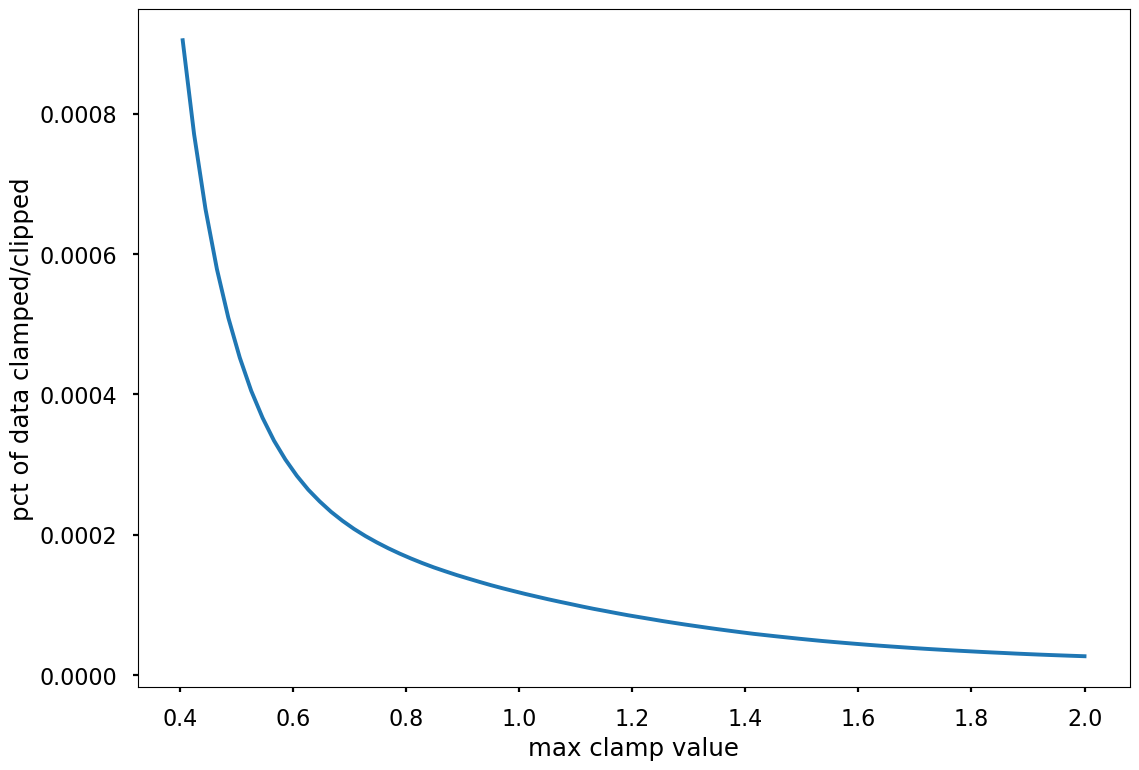

In [37]:
plt.plot(max_threshs[20:], pct_clamped[20:])
plt.xlabel('max clamp value')
plt.ylabel('pct of data clamped/clipped')
plt.show()

In [6]:
max_thresh_clamp = 0.6

In [30]:
X_tr_quant, meta = uniform_width_quantize(X_tr, v_min=min_thresh_clamp, v_max=max_thresh_clamp, \
                                    n_bins=None, n_bits=8, out_dtype=torch.uint8)
X_te_quant, _ = uniform_width_quantize(X_te, v_min=min_thresh_clamp, v_max=max_thresh_clamp, \
                                    n_bins=None, n_bits=8, out_dtype=torch.uint8)

In [32]:
comp_data = {
        'train':{
            'Z': X_tr_quant,
            'y': y_tr
        },
        'test': {
            'Z': X_te_quant,
            'y': y_te
        }
    }
torch.save(comp_data, f'data/comp/geoSSL-fmow-quantize_unif_uint8.pt')
torch.save(meta, f'compress_models/geoSSL-fmow-quantize_unif_uint8.pt')

## generalization to other datasets

In [82]:
for quant_type, dtype in [('unif_uint8', torch.uint8), ('unif_int15', torch.int16)]:
    data_path = f'data/comp/geoSSL-ucmerced-quantize_{quant_type}.pt'
    model_path = f'compress_models/geoSSL-fmow-quantize_{quant_type}.pt'
    metadata = torch.load(model_path)
    X_tr_quant, _ = uniform_width_quantize(X_tr, **metadata, out_dtype=dtype)
    X_te_quant, _ = uniform_width_quantize(X_te, **metadata, out_dtype=dtype)
    comp_data = {
        'train':{
            'Z': X_tr_quant,
            'y': y_tr
        },
        'test': {
            'Z': X_te_quant,
            'y': y_te
        }
    }
    torch.save(comp_data, data_path)

## Quantized training

In [17]:
cfg.compress_type = 'unif_quant'

In [18]:
for quant_type in ['unif_uint8']:
    base_name = f'geoSSL-fmow-quantize_{quant_type}'
    data_path = f'data/comp/{base_name}.pt'
    model_path = f'compress_models/{base_name}.pt'.replace('ucmerced', 'fmow')
    data = torch.load(data_path)
    X_tr_quant = data['train']['Z']
    y_tr_apx = data['train']['y']
    X_te_quant = data['test']['Z']
    y_te_apx = data['test']['y']
    
    metadata = torch.load(model_path)
    X_tr_apx = uniform_width_dequantize(X_tr_quant, **metadata, out_dtype=torch.float32)
    X_te_apx = uniform_width_dequantize(X_te_quant, **metadata, out_dtype=torch.float32)
    
    z_dim = X_tr_apx.shape[-1]
    model = MultiLayerMLP(dims=[z_dim, 2048, 1024, 62], dropouts=[.5,.5])
    
    run_name = base_name+'-mlp'
    run_training(X_tr_apx, y_tr_apx, X_te_apx, y_te_apx, run_name=run_name, cfg=cfg, model=model)

prepping for training
starting training


best=0.710: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|162900/162900


wandb: ERROR Control-C detected -- Run data was not synced


# eig projection + quantization
(preload the functions in other parts)

In [24]:
PROJ_DIM = [100, 150, 200]
QUANTIZATIONS = [('unif_uint8', torch.uint8)]

In [25]:
def approx_from_quantized_projection(X_proj_quant, model):
    X_proj_apx = uniform_width_dequantize(X_proj_quant, **model['quant_metadata'], out_dtype=torch.float32)
    X_apx = eig_decompress(X_proj_apx, model['U'])
    return X_apx

## figuring out good clamp values

In [124]:
base_name = f'geoSSL-fmow-center_eig_proj200'
data_path = f'data/comp/{base_name}.pt'
data = torch.load(data_path)
X_tr_proj = data['train']['Z']
y_tr_apx = data['train']['y']
X_te_proj = data['test']['Z']
y_te_apx = data['test']['y']

In [117]:
max_threshs = np.linspace(0.5, 4.5, num=100)
pct_max_clamped = []
total_len = len(X_tr_proj.flatten())
for t in tqdm(max_threshs):
    pct_max_clamped.append((X_tr_proj > t).sum()/total_len)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.13it/s]


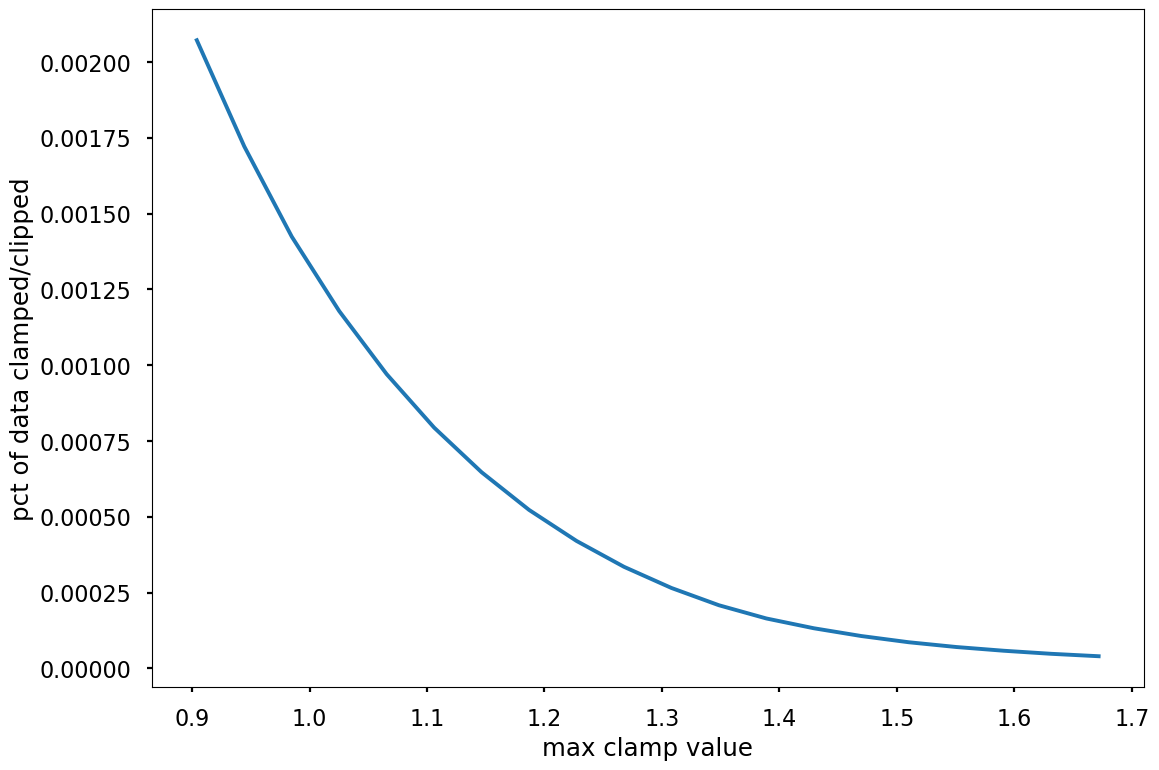

In [122]:
plt.plot(max_threshs[10:30], pct_max_clamped[10:30])
plt.xlabel('max clamp value')
plt.ylabel('pct of data clamped/clipped')
plt.show()

In [120]:
min_threshs = np.linspace(-1, 0, num=100)
pct_min_clamped = []
total_len = len(X_tr_proj.flatten())
for t in tqdm(min_threshs):
    pct_min_clamped.append((X_tr_proj < t).sum()/total_len)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.20it/s]


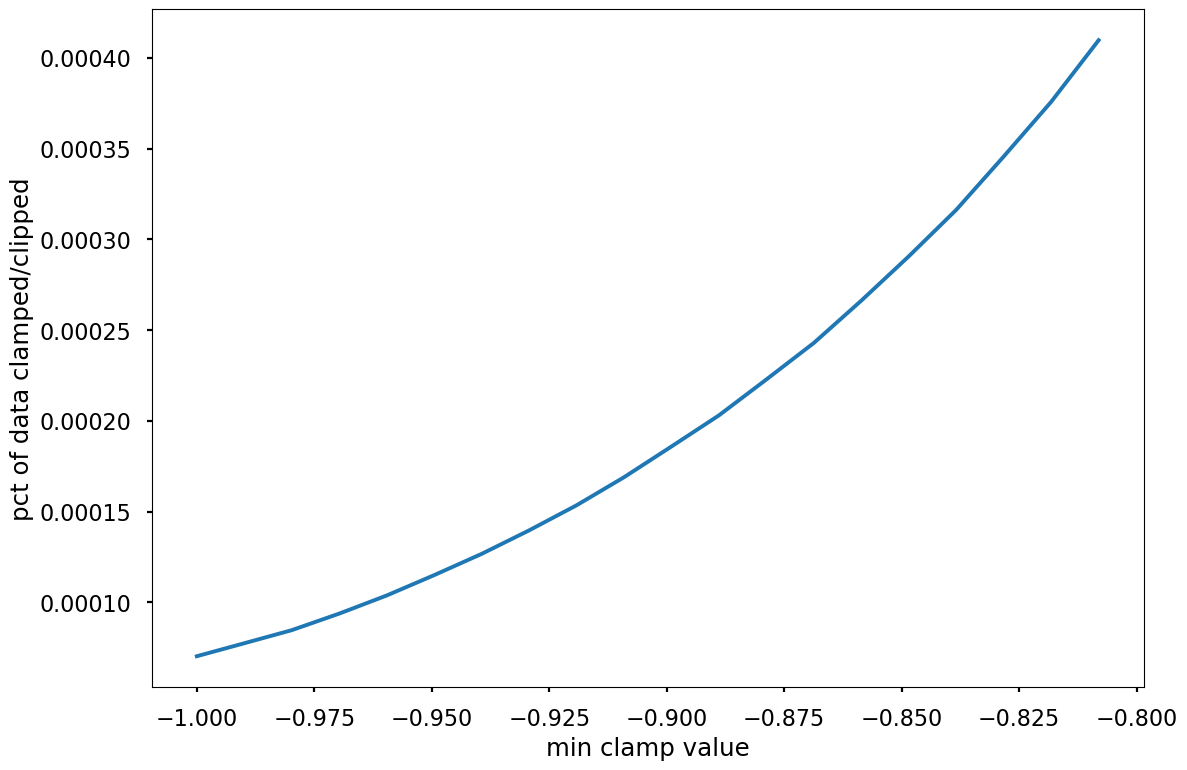

In [123]:
plt.plot(min_threshs[:20], pct_min_clamped[:20])
plt.xlabel('min clamp value')
plt.ylabel('pct of data clamped/clipped')
plt.show()

to clip a very small amount of data, -1 to 1.5 seems reasonable (lol)

## project and quantize

Note: makes use of pre-existing projected data

In [140]:
min_thresh = -1
max_thresh = 1.5
for psz in PROJ_DIM:
    base_name = f'geoSSL-fmow-center_eig_proj{psz}'
    data_path = f'data/comp/{base_name}.pt'
    
    data = torch.load(data_path)
    X_tr_proj = data['train']['Z']
    y_tr_apx = data['train']['y']
    X_te_proj = data['test']['Z']
    y_te_apx = data['test']['y']
    model_path = f'compress_models/{base_name}.pt'.replace('ucmerced', 'fmow')
    U = torch.load(model_path)
    for quant_name, dtype in QUANTIZATIONS:
        b = torch.iinfo(dtype).bits - (torch.iinfo(dtype).min < 0)
        X_tr_proj_quant, _ = uniform_width_quantize(X_tr_proj, v_min=min_thresh, v_max=max_thresh, \
                                                       n_bins=None, n_bits=b, out_dtype=dtype)
        X_te_proj_quant, _ = uniform_width_quantize(X_te_proj, v_min=min_thresh, v_max=max_thresh, \
                                                    n_bins=None, n_bits=b, out_dtype=dtype)
        comp_data = {
            'train':{
                'Z': X_tr_proj_quant,
                'y': y_tr_apx
            },
            'test': {
                'Z': X_te_proj_quant,
                'y': y_te_apx
            }
        }
        
        model_data = {
            'U': U,
            'quant_metadata': meta
        }
        torch.save(comp_data, f'data/comp/{base_name}-quantize_{quant_name}.pt')
        torch.save(model_data, f'compress_models/{base_name}-quantize_{quant_name}.pt')
        print('saved data to:', f'data/comp/{base_name}-quantize_{quant_name}.pt')

saved data to: data/comp/geoSSL-fmow-center_eig_proj100-quantize_unif_uint8.pt
saved data to: data/comp/geoSSL-fmow-center_eig_proj150-quantize_unif_uint8.pt
saved data to: data/comp/geoSSL-fmow-center_eig_proj200-quantize_unif_uint8.pt


## generalized pipeline

Note: makes use of pre-existing projected data

In [151]:
gen_dset = 'ucmerced'
for psz in PROJ_DIM:
    base_name = f'geoSSL-{gen_dset}-center_eig_proj{psz}'
    data_path = f'data/comp/{base_name}.pt'
    data = torch.load(data_path)
    X_tr_proj = data['train']['Z']
    y_tr_apx = data['train']['y']
    X_te_proj = data['test']['Z']
    y_te_apx = data['test']['y']
    
    for quant_name, _ in QUANTIZATIONS:
        model_path = f'compress_models/{base_name}-quantize_{quant_name}.pt'.replace(gen_dset, 'fmow')
        meta = torch.load(model_path)['quant_metadata']
        X_tr_proj_quant, _ = uniform_width_quantize(X_tr_proj, **meta, out_dtype=dtype)
        X_te_proj_quant, _ = uniform_width_quantize(X_te_proj, **meta, out_dtype=dtype)
        comp_data = {
            'train':{
                'Z': X_tr_proj_quant,
                'y': y_tr_apx
            },
            'test': {
                'Z': X_te_proj_quant,
                'y': y_te_apx
            }
        }
        torch.save(comp_data, f'data/comp/{base_name}-quantize_{quant_name}.pt')
        print('saved data to:', f'data/comp/{base_name}-quantize_{quant_name}.pt')

saved data to: data/comp/geoSSL-ucmerced-center_eig_proj100-quantize_unif_uint8.pt
saved data to: data/comp/geoSSL-ucmerced-center_eig_proj150-quantize_unif_uint8.pt
saved data to: data/comp/geoSSL-ucmerced-center_eig_proj200-quantize_unif_uint8.pt


## training

In [40]:
cfg.compress_type = 'center_eig_proj_unif_quant'

In [44]:
dset = 'fmow'
for psz in PROJ_DIM:
    for quant_name, _ in QUANTIZATIONS:
        base_name = f'geoSSL-{dset}-center_eig_proj{psz}-quantize_{quant_name}'
        data_path = f'data/comp/{base_name}.pt'
        comp_model_path = f'compress_models/{base_name}.pt'.replace(dset, 'fmow')

        data = torch.load(data_path)
        X_tr_comp = data['train']['Z']
        y_tr_apx = data['train']['y']
        X_te_comp = data['test']['Z']
        y_te_apx = data['test']['y']
        
        comp_model = torch.load(comp_model_path)
        X_tr_apx = approx_from_quantized_projection(X_tr_comp, comp_model)
        X_te_apx = approx_from_quantized_projection(X_te_comp, comp_model)
        
        z_dim = X_tr_apx.shape[-1]
        model = MultiLayerMLP(dims=[z_dim, 2048, 1024, 62], dropouts=[.5,.5])
        run_name = base_name+'-mlp'
        run_training(X_tr_apx, y_tr_apx, X_te_apx, y_te_apx, run_name=run_name, cfg=cfg, model=model)

prepping for training
starting training


best=0.693: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|81450/81450


best_val acc,▁
train acc,▁▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
train loss,█▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▁▃▄▄▅▆▆▆▇▇▇▇▇▇█▇████████████████████████
val loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂
best_val acc,0.69316
train acc,0.78464
train loss,0.71082
val acc,0.69161
val loss,1.12296


prepping for training
starting training


best=0.699: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|81450/81450


best_val acc,▁
train acc,▁▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▁▃▄▅▆▆▆▇▇▇▇▇█▇██████████████████████████
val loss,█▆▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂
best_val acc,0.69868
train acc,0.81017
train loss,0.62266
val acc,0.69838
val loss,1.12292


prepping for training
starting training


best=0.703: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|81450/81450


best_val acc,▁
train acc,▁▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
train loss,█▅▅▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val acc,▁▃▄▅▆▆▆▇▇▇▇▇████████████████████████████
val loss,█▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃
best_val acc,0.70288
train acc,0.82692
train loss,0.56455
val acc,0.70158
val loss,1.1299


# autoencoder

In [10]:
def encode_data(X, ae_model, bsz=256, device='cuda:0'):
    X_enc = []
    ae_model.to(device)
    ae_model.eval()
    with torch.no_grad():
        for i in range(0, len(X), bsz):
            batch = X[i:i+bsz].to(device)
            X_enc.append(ae_model.encode(batch).cpu())
        X_enc = torch.cat(X_enc, dim=0)
        return X_enc

def decode_data(X_enc, ae_model, bsz=256, device='cuda:0'):
    X_dec = []
    ae_model.to(device)
    ae_model.eval()
    with torch.no_grad():
        for i in range(0, len(X_enc), bsz):
            batch = X_enc[i:i+bsz].to(device)
            X_dec.append(ae_model.decode(batch).cpu())
        X_dec = torch.cat(X_dec, dim=0)
        return X_dec

In [11]:
bottlenecks = [200]

## run ae training

In [9]:
ae_cfg = DotDict(
        n_epochs=60,
        lr=1e-4,
        wd=0,
        bsz=256,
        device='cuda:0'
)

In [ ]:
z_dim = X_tr.shape[-1]
dims = [z_dim, 1024, 0]
for bn_dim in bottlenecks:
    dims[-1] = bn_dim
    ae_cfg.arch = '_'.join([str(d) for d in dims])
    dropouts = .2
    model = MLPAutoEncoder(dims=dims, dropouts=dropouts)
    run_name = f'fmow_trained_ae-{ae_cfg.arch}'
    run_ae_training(X_tr, X_te, model, run_name=run_name, cfg=ae_cfg)

prepping for training
starting training


best=0.000: 41%|██████████████████████████████████████████████████▉                                                                          |39867/97740

## extract compressed features

In [12]:
# TEMP
path = 'fmow_trained_ae-2048_1024_200'
savename = 'geoSSL-ucmerced-ae_2048_1024_200'
comp_model = MLPAutoEncoder(dims=[2048, 1024, 200], dropouts=0.5)
state = torch.load(f'compress_models/{path}.pt')
comp_model.load_state_dict(state)
X_tr_enc = encode_data(X_tr, comp_model, bsz=256, device='cuda:0')
X_te_enc = encode_data(X_te, comp_model, bsz=256, device='cuda:0')
# assert X_tr_enc.shape[-1] == bn_dim
comp_data = {
    'train':{
        'Z': X_tr_enc,
        'y': y_tr
    },
    'test': {
        'Z': X_te_enc,
        'y': y_te
    }
}
torch.save(comp_data, f'data/comp/{savename}.pt')
X_tr_dec = decode_data(X_tr_enc, comp_model, bsz=256, device='cuda:0')
X_te_dec = decode_data(X_te_enc, comp_model, bsz=256, device='cuda:0')
decomp_data = {
    'train':{
        'Z': X_tr_dec,
        'y': y_tr
    },
    'test': {
        'Z': X_te_dec,
        'y': y_te
    }
}
torch.save(decomp_data, f'data/decomp/{savename}.pt')
print(f'saved data')

saved data


In [ ]:
for bn_dim in bottlenecks:
    comp_model = MLPAutoEncoder(dims=[2048, 1024, bn_dim], dropouts=0.2)
    state = torch.load(f'compress_models/fmow_trained_ae-bn{bn_dim}.pt')
    comp_model.load_state_dict(state)
    X_tr_enc = encode_data(X_tr, comp_model, bsz=256, device='cuda:0')
    X_te_enc = encode_data(X_te, comp_model, bsz=256, device='cuda:0')
    assert X_tr_enc.shape[-1] == bn_dim
    comp_data = {
        'train':{
            'Z': X_tr_enc,
            'y': y_tr
        },
        'test': {
            'Z': X_te_enc,
            'y': y_te
        }
    }
    torch.save(comp_data, f'data/comp/geoSSL-fmow-ae_bn{bn_dim}.pt')
    X_tr_dec = decode_data(X_tr_enc, comp_model, bsz=256, device='cuda:0')
    X_te_dec = decode_data(X_te_enc, comp_model, bsz=256, device='cuda:0')
    decomp_data = {
        'train':{
            'Z': X_tr_dec,
            'y': y_tr
        },
        'test': {
            'Z': X_te_dec,
            'y': y_te
        }
    }
    torch.save(decomp_data, f'data/decomp/geoSSL-fmow-ae_bn{bn_dim}.pt')
    print(f'saved bn{bn_dim} data')

saved bn150 data
saved bn100 data
saved bn50 data


## classify on compressed version

In [15]:
cfg.compress_type = f'ae_bn200'
data_path = f'data/decomp/geoSSL-ucmerced-ae_2048_1024_200.pt'
data = torch.load(data_path)
X_tr_apx = data['train']['Z']
y_tr_apx = data['train']['y']
X_te_apx = data['test']['Z']
y_te_apx = data['test']['y']

# z_dim = X_tr_apx.shape[-1]
model = None# MultiLayerMLP(dims=[z_dim, 2048, 1024, 62], dropouts=[.5,.5])

run_name = 'geoSSL-ucmerced-ae_2048_1024_200'
run_training(X_tr_apx, y_tr_apx, X_te_apx, y_te_apx, run_name=run_name, cfg=cfg, model=model)

prepping for training
starting training


best=0.929: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|7000/7000


best_val acc,▁
train acc,▁▄▆▇▇▇▇▇▇▇██████████████████████████████
train loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val acc,▁▄▆▇▇▇▇█████████████████████████████████
val loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val acc,0.92857
train acc,0.96905
train loss,0.303
val acc,0.92857
val loss,0.40063


In [ ]:
for bn_dim in bottlenecks:
    cfg.compress_type = f'ae_bn{bn_dim}'
    base_name = f'geoSSL-fmow-{cfg.compress_type}'
    data_path = f'data/decomp/{base_name}.pt'
    data = torch.load(data_path)
    X_tr_apx = data['train']['Z']
    y_tr_apx = data['train']['y']
    X_te_apx = data['test']['Z']
    y_te_apx = data['test']['y']

    # z_dim = X_tr_apx.shape[-1]
    model = None#MultiLayerMLP(dims=[z_dim, 2048, 1024, 62], dropouts=[.5,.5])

    run_name = base_name#+'-mlp2'
    run_training(X_tr_apx, y_tr_apx, X_te_apx, y_te_apx, run_name=run_name, cfg=cfg, model=model)

prepping for training
starting training


wandb: Currently logged in as: cpolzak. Use `wandb login --relogin` to force relogin


best=0.627: 62%|████████████████████████████████████████████████████████████████████████████▍                                              |101217/162900